## Mean Encoding or Target Encoding

[Feature Engineering for Machine Learning Course](https://www.trainindata.com/p/feature-engineering-for-machine-learning)

Mean encoding implies replacing the category by the average target value for that category. For example, if we have the variable city, with categories London, Manchester and Bristol, and we want to predict the default rate, if the default rate for London is 30% we replace London by 0.3, if the default rate for Manchester is 20% we replace Manchester by 0.2 and so on.


## In this demo:

We will see how to perform one hot encoding with pandas using the Titanic dataset.

For guidelines to obtain the dataset, visit **section 2** of the course.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load dataset

data = pd.read_csv(
    "../../Datasets/titanic.csv", usecols=["cabin", "sex", "embarked", "survived"]
)

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data["cabin"] = data["cabin"].astype(str).str[0]

In [4]:
# let's fill na

data.fillna("Missing", inplace=True)

In [5]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ": ", len(data[col].unique()), " labels")

survived :  2  labels
sex :  2  labels
cabin :  9  labels
embarked :  4  labels


In [6]:
# omd

for col in data.columns:
    print(f"{col}: {data[col].nunique()} labels")

survived: 2 labels
sex: 2 labels
cabin: 9 labels
embarked: 4 labels


In [7]:
# let's explore the unique categories

data["cabin"].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [8]:
data["sex"].unique()

array(['female', 'male'], dtype=object)

In [9]:
data["embarked"].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Encoding important

We calculate the target mean per category using the train set, and then use those mappings in the test set.

In [10]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[["cabin", "sex", "embarked"]],
    data["survived"],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 3), (393, 3))

### Explore original relationship between categorical variables and target

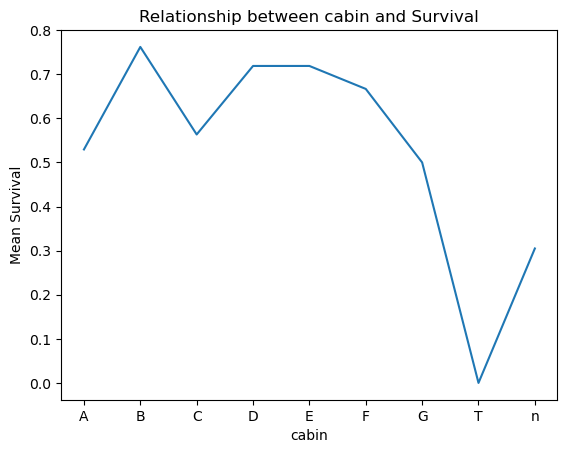

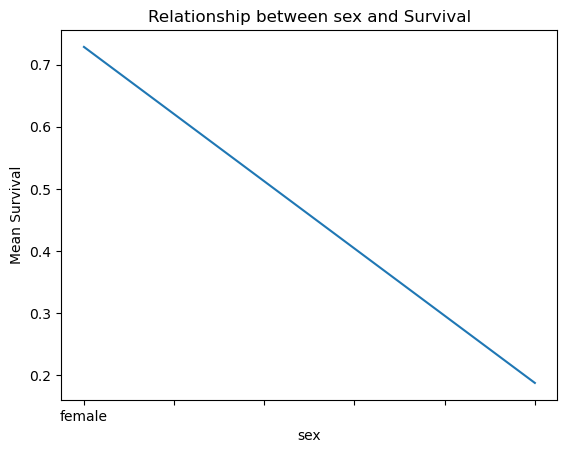

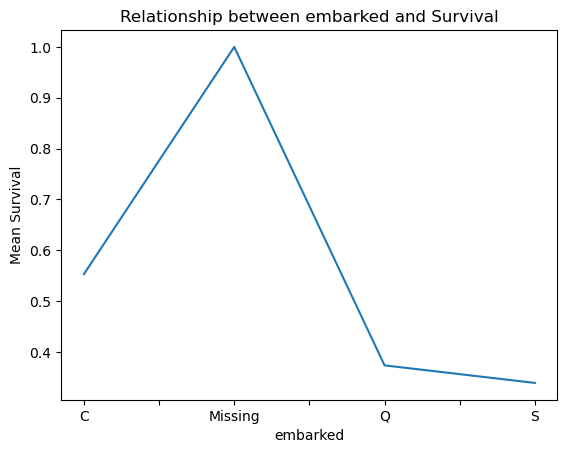

In [11]:
# let's explore the relationship of the categories with the target

for var in ["cabin", "sex", "embarked"]:

    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survival")
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Mean encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [12]:
# omd
# Demonstration that ordinal and mean encoding show the same relationship between category and target variable
from sklearn.base import BaseEstimator, TransformerMixin

class MonotonicEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables, encoding='ordinal'):
        if not isinstance(variables, list):
            raise ValueError('"Variables" should be a list.')
        if encoding not in ['ordinal', 'mean']:
            raise ValueError('Encoding method should be "ordinal" or "mean".')
        self.variables = variables
        self.encoding = encoding

    def fit(self, X, y):
        self.mapping_dict_collection = []
        self.categories = []
        if self.encoding == "ordinal":
            for var in self.variables:
                self.ordered_list = y.groupby(X[var]).mean().sort_values(ascending=True).index
                self.ordinal_mapping_dict = {j: i for i, j in enumerate(self.ordered_list, 0)}
                self.mapping_dict_collection.append(self.ordinal_mapping_dict)
                self.categories.append(self.ordinal_mapping_dict.keys())
        else:  # in this case, encoding must be mean-encoding
            for var in self.variables:
                self.mean_mapping_dict = y.groupby(X[var]).mean().sort_values(ascending=True).to_dict()
                self.mapping_dict_collection.append(self.mean_mapping_dict)
                self.categories.append(list(self.mean_mapping_dict.keys()))
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for i, var in enumerate(self.variables):
            X[var] = X[var].map(self.mapping_dict_collection[i])
        return X 
    
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

In [49]:
# omd

train = X_train.copy()
test = X_test.copy()
encoder = MonotonicEncoder(variables=["cabin", "sex", "embarked"], encoding='mean')
train = encoder.fit_transform(train, y_train)
test = encoder.transform(test)

In [51]:
# omd 
encoder.mapping_dict_collection[0]

{'T': 0.0,
 'n': 0.30484330484330485,
 'G': 0.5,
 'A': 0.5294117647058824,
 'C': 0.5633802816901409,
 'F': 0.6666666666666666,
 'D': 0.71875,
 'E': 0.71875,
 'B': 0.7619047619047619}

In [50]:
# omd 
y_train.groupby(X_train['cabin']).mean().sort_values(ascending=True).to_dict()

{'T': 0.0,
 'n': 0.30484330484330485,
 'G': 0.5,
 'A': 0.5294117647058824,
 'C': 0.5633802816901409,
 'F': 0.6666666666666666,
 'D': 0.71875,
 'E': 0.71875,
 'B': 0.7619047619047619}

In [46]:
# omd
t1 = y_train.groupby(train['cabin'], dropna=False).mean().to_frame()
t2 = y_test.groupby(test['cabin'], dropna=False).mean()
t3 = pd.merge(left=t1, right=t2, left_index=True, right_index=True, how='left')
t1

,survived
cabin,
0.000000,0.000000
0.304843,0.304843
0.500000,0.500000
0.529412,0.529412
0.563380,0.563380
0.666667,0.666667
0.718750,0.718750
0.761905,0.761905


In [41]:
data['cabin'].value_counts(dropna=False)

cabin
n    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64

In [37]:
encoder.mapping_dict_collection[0]

{'T': 0.0,
 'n': 0.30484330484330485,
 'G': 0.5,
 'A': 0.5294117647058824,
 'C': 0.5633802816901409,
 'F': 0.6666666666666666,
 'D': 0.71875,
 'E': 0.71875,
 'B': 0.7619047619047619}

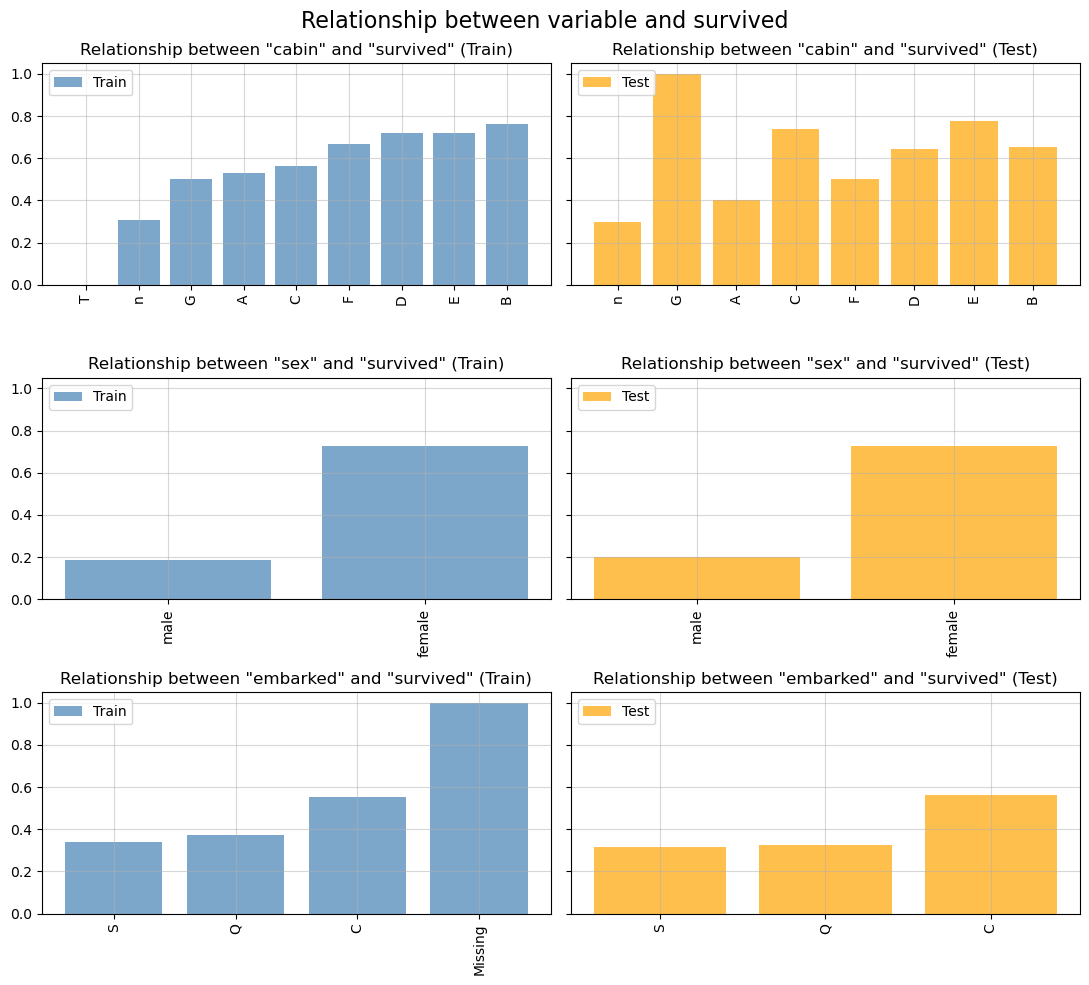

In [29]:
# omd

# Create a figure and subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 10), sharey=True)

# Set common title
fig.suptitle('Relationship between variable and survived', fontsize=16)

# Iterate through variables
for i, var in enumerate(["cabin", "sex", "embarked"]):
    # create results dataset for train and test
    t1 = y_train.groupby(train[var]).mean().to_frame()
    t2 = y_test.groupby(test[var]).mean()
    t3 = pd.merge(left=t1, right=t2, left_index=True, right_index=True, how='outer')  # will ensure that train & test have the same number of categories per variable
    
    # Plot train data
    axes[i, 0].bar(x=list(encoder.categories[i]), height=t3['survived_x'], label='Train', color='steelblue', alpha=0.7)
    axes[i, 0].set_title(f'Relationship between "{var}" and "survived" (Train)')
    axes[i, 0].legend(loc='upper left')
    axes[i, 0].tick_params(axis='x', rotation=90)
    axes[i, 0].grid(True, alpha=0.5)

    # Plot test data
    axes[i, 1].bar(x=list(encoder.categories[i]), height=t3['survived_y'], label='Test', color='orange', alpha=0.7)
    axes[i, 1].set_title(f'Relationship between "{var}" and "survived" (Test)')
    axes[i, 1].legend(loc='upper left')
    axes[i, 1].tick_params(axis='x', rotation=90)
    axes[i, 1].grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [52]:
# let's calculate the mean target value per category for cabin

y_train.groupby(X_train["cabin"]).mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

In [53]:
# and now let's do the same but capturing the result in a dictionary

ordered_labels = y_train.groupby(X_train["cabin"]).mean().to_dict()

ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [54]:
# now, we replace the labels with the target means

X_train["cabin"] = X_train["cabin"].map(ordered_labels)
X_test["cabin"] = X_test["cabin"].map(ordered_labels)

In [55]:
# let's explore the result

X_train["cabin"].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

In [56]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):
    return target.groupby(df[variable]).mean().to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [57]:
# and now we run a loop over the remaining categorical variables

for variable in ["sex", "embarked"]:
    mappings = find_category_mappings(X_train, variable, y_train)
    integer_encode(X_train, X_test, variable, mappings)

In [17]:
# let's see the result

X_train.head()

,cabin,sex,embarked
501,0.304843,0.728358,0.338957
588,0.304843,0.728358,0.338957
402,0.304843,0.728358,0.553073
1193,0.304843,0.187608,0.373494
686,0.304843,0.728358,0.373494


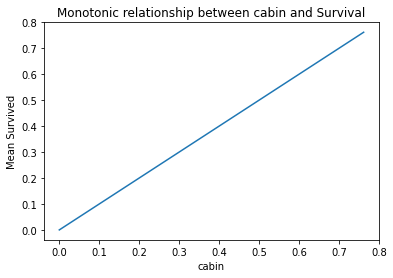

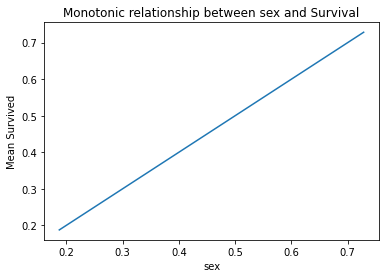

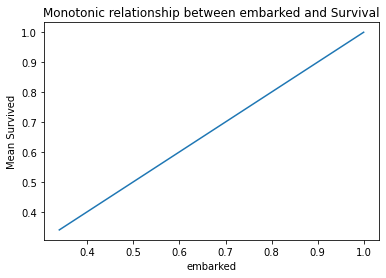

In [18]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ["cabin", "sex", "embarked"]:

    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Monotonic relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survived")
    plt.show()

Mean Encoding creates linear relationships between the mean target and the categories.

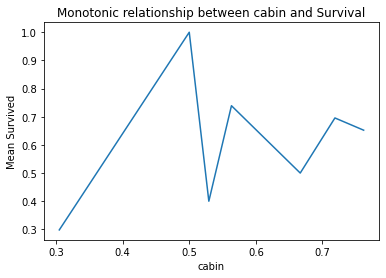

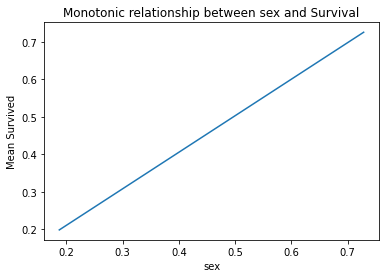

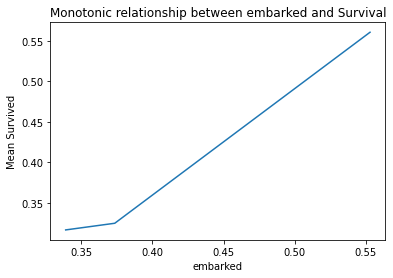

In [19]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ["cabin", "sex", "embarked"]:

    fig = plt.figure()
    fig = y_test.groupby(X_test[var]).mean().plot()
    fig.set_title("Monotonic relationship between {} and Survival".format(var))
    fig.set_ylabel("Mean Survived")
    plt.show()

The monotonic relationship for embarked is preserved in the test set, but not for cabin. This means that this encoding will not make cabin suitable for linear models.